In [ ]:
# default_exp engine.psf

In [ ]:
%load_ext autoreload
%autoreload 2

# PSF model

> Definition of the classes and modules we use to model PSFs

In [ ]:
#export
from decode_fish.imports import *
import torch.nn as nn
from torch.jit import script
from typing import Union, List
import torch.nn.functional as F
from decode_fish.funcs.utils import *
from decode_fish.funcs.plotting import *

In [ ]:
#export
class LinearInterpolatedPSF(nn.Module):
    """
    Linearly interpolates psf volume with offsets
    """

    def __init__(self, size_zyx ,upsample_factor=3, device='cuda'):
        super().__init__()
        
        self.upsampled_psf_size = list((upsample_factor*(np.array(size_zyx)-1)+1).astype('int'))
        # +- /sz so that the values correspond to the pixel centers
        v = [torch.linspace(-1+1/sz, 1-1/sz, int(sz)) for sz in self.upsampled_psf_size]

        self.register_buffer('x', v[2])
        self.register_buffer('y', v[1])
        self.register_buffer('z', v[0])
        self.device=device
        self.psf_volume = nn.Parameter(0.01*torch.rand(1, *self.upsampled_psf_size))
        
    def forward(self, x_offset_val, y_offset_val, z_offset_val):

        N_em = x_offset_val.shape[0]
        # Scale offsets by size. Factor of two because range [-1,1]
        x_offset = 2 * x_offset_val.view(-1) / self.upsampled_psf_size[2]  
        y_offset = 2 * y_offset_val.view(-1) / self.upsampled_psf_size[1]
        z_offset = 2 * z_offset_val.view(-1) / self.upsampled_psf_size[0]
        i_img, x_grid, y_grid, z_grid = torch.meshgrid(torch.arange(N_em, dtype=torch.float32).to(self.device), self.x.to(self.device), self.y.to(self.device), self.z.to(self.device))

        x_grid = x_grid - x_offset[:, None, None, None]
        y_grid = y_grid - y_offset[:, None, None, None]
        z_grid = z_grid - z_offset[:, None, None, None]

        m_grid = torch.stack([x_grid, y_grid, z_grid], -1)
        psf_out = torch.nn.functional.grid_sample(self.psf_volume.expand(N_em, -1, -1, -1, -1).to(self.device), m_grid, align_corners = False)
        
        return psf_out.transpose(-3,-1)

In [ ]:
#export
def crop_psf(psf, extent_zyx):

    cropped_vol = center_crop(psf.psf_volume, extent_zyx)
    cropped_psf = LinearInterpolatedPSF(extent_zyx, upsample_factor= 1)
    cropped_psf.psf_volume.data = cropped_vol
    
    return cropped_psf

In [ ]:
psf_state = torch.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/simfish_psf.pkl')
shape_zyx = psf_state['psf_volume'][:,].shape[-3:]
psf = LinearInterpolatedPSF(shape_zyx, upsample_factor= 1)
psf.psf_volume.data = psf_state['psf_volume'][:,]

/groups/turaga/home/speisera/anaconda3/envs/decode2_dev/lib/python3.7/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


torch.Size([1, 1, 31, 31, 31])

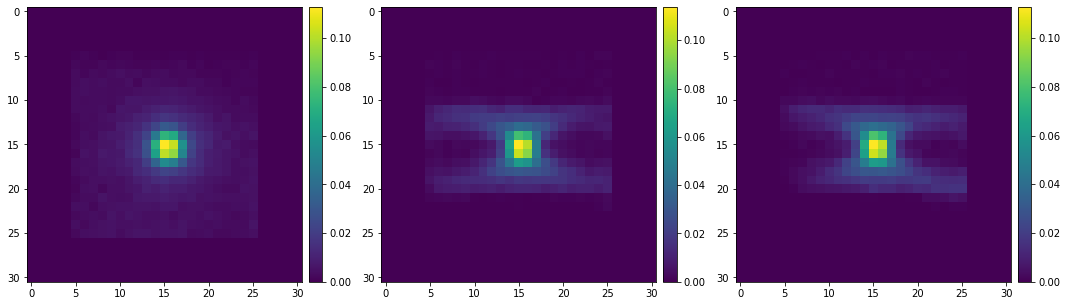

In [ ]:
shift = psf(torch.tensor([-2,0.,+2]).cuda(),0.+torch.zeros(3).cuda(),0.+torch.zeros(3).cuda())
shift = psf(0.+torch.zeros(1).cuda(),0.+torch.zeros(1).cuda(),0.+torch.zeros(1).cuda())
plot_3d_projections(shift.cpu().detach().numpy()[0,0])
shift.shape

In [ ]:
cropped_psf = crop_psf(psf,[11,21,21])

torch.Size([1, 11, 21, 21])
torch.Size([21]) torch.Size([21]) torch.Size([11])


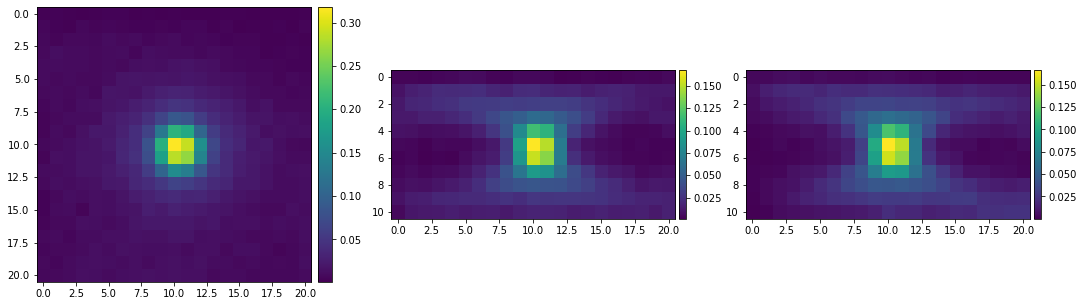

In [ ]:
plot_3d_projections(cropped_psf.psf_volume.detach().numpy()[0])
print(cropped_psf.psf_volume.shape)
print(cropped_psf.x.shape,cropped_psf.y.shape,cropped_psf.z.shape)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train_sl.ipynb.
Converted 14_train_ae.ipynb.
Converted 15_fit_psf.ipynb.
Converted index.ipynb.
